In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# With Embedding 

RBF + Logistic Regression on emoji2text2bert embedding 

In [2]:
def getdfs(data : str, train_size : float = 1):
    '''
    preprocess and return train_df and val_df
    '''
    if data not in ['text_seq', 'feature' , 'emoticon']:
        raise ValueError("Invalid data type")
    
    if data == 'feature' : 
        train_df = np.load(f"/Users/siya/Desktop/datasets/train/train_{data}.npz") 
        valid_df = np.load(f"/Users/siya/Desktop/datasets/valid/valid_{data}.npz")
    else :
        train_df = pd.read_csv(f"/Users/siya/Desktop/datasets/train/train_{data}.csv")
        val_df = pd.read_csv(f"/Users/siya/Desktop/datasets/valid/valid_{data}.csv")
    
    train_df = train_df[:int(len(train_df)*train_size)]

    def get_char_columns(df):
        for i in range(len(df['input_emoticon'][0])):
            df[f'c_{i+1}'] = df['input_emoticon'].apply(lambda x, _i=i: x[_i])
        
        return df[df.columns.to_list()[2:] + ['label']]

    if data == 'emoticon':
        train_df = get_char_columns(train_df)
        val_df = get_char_columns(val_df)

    return train_df, val_df

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import demoji

train_df, val_df = getdfs('emoticon')

for i in range(13) :
    train_df[f'c_{i+1}_text'] = train_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)
    val_df[f'c_{i+1}_text'] = val_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def text2embed(text) :
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1)

    return sentence_embedding.numpy().reshape(-1)

texts = []
for i in range(13) :
    for text in train_df[f'c_{i+1}_text'] :
        texts.append(text)
texts = list(set(texts))

dict_text2bed = {f'{text}' : text2embed(text) for text in texts}

def embed_df(df : pd.DataFrame, embedding_dim : int = 768, num_columns: int = 13)-> pd.DataFrame :

    # Initialize a list to store rows of combined embeddings
    combined_embeddings = []

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        row_embeddings = []
        
        # Iterate over the 13 columns and get the embedding for each
        for i in range(num_columns):
            column_text = row[f'c_{i+1}_text']
            
            # If the text is not empty, fetch its embedding, else use a zero vector
            if column_text != '':
                embedding = dict_text2bed.get(column_text, np.zeros(embedding_dim))
            else:
                embedding = np.zeros(embedding_dim)
            
            # Append the embedding to the row list
            row_embeddings.append(embedding)
        
        # Concatenate the embeddings for the row
        combined_embeddings.append(np.hstack(row_embeddings))

    # Convert the list of rows into a NumPy array
    X = np.vstack(combined_embeddings)
    
    return X

X_train = embed_df(train_df)
y_train = train_df['label']

X_val = embed_df(val_df)
y_val = val_df['label']

/Users/siya/CS771 mini project /myproject_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy with RBF kernel approximation using Logistic Regression: 55.6237%


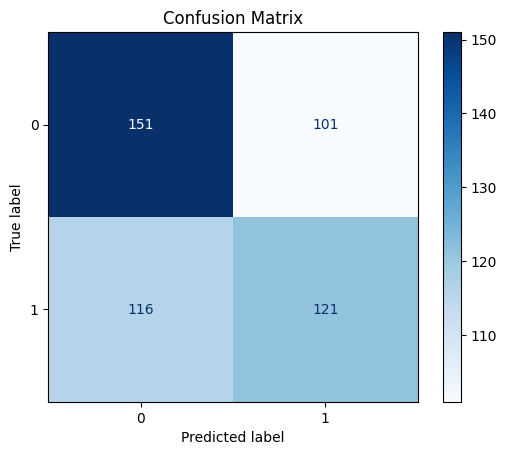

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt

# X_train.shape : (7080, 9984)

# Define the RBF kernel approximation
gamma = 1.0  
rbf_feature = RBFSampler(gamma=gamma, n_components=80, random_state=42)  

# Transform the training and validation datasets
X_train_rbf = rbf_feature.fit_transform(X_train)
X_valid_rbf = rbf_feature.transform(X_val)

# Train a Logistic Regression model with the RBF kernel approximation
model = LogisticRegression(max_iter=100)  # Increase iterations if needed for convergence
model.fit(X_train_rbf, y_train)

# Make predictions
y_pred = model.predict(X_valid_rbf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy with RBF kernel approximation using Logistic Regression: {accuracy*100:.4f}%')

# Compute Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Without Embedding 

In [5]:
# read emoticon dataset
train_emoticon_df = pd.read_csv("/Users/siya/Desktop/datasets/train/train_emoticon.csv")
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
train_emoticon_Y = train_emoticon_df['label'].tolist()

valid_emoticon_X = pd.read_csv("/Users/siya/Desktop/datasets/valid/valid_emoticon.csv")['input_emoticon'].tolist()
valid_emoticon_Y = pd.read_csv("/Users/siya/Desktop/datasets/valid/valid_emoticon.csv")['label'].tolist()

### mlp with RBF Kernel 

Accuracy with RBF transformation and MLPClassifier: 50.9202%


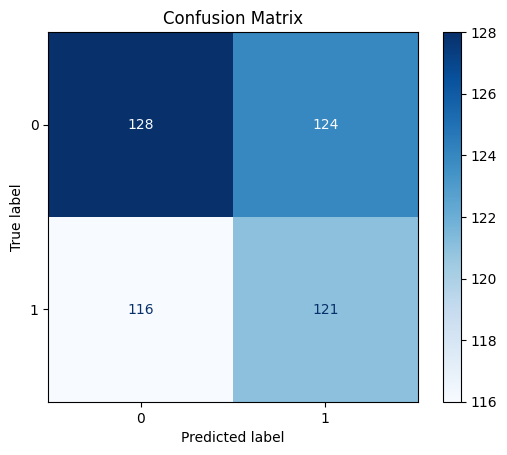

In [6]:
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert emoticons to Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Applying RBF transformation
rbf_feature = RBFSampler(gamma=1.0, random_state=42)  
X_train_rbf = rbf_feature.fit_transform(X_train)
X_valid_rbf = rbf_feature.transform(X_valid)

# Train MLPClassifier with transformed features
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  
model.fit(X_train_rbf, y_train)

# predictions
y_pred = model.predict(X_valid_rbf)

# Evaluating the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with RBF transformation and MLPClassifier: {accuracy*100:.4f}%')

# Compute and plotting the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### random forest with RBF kernel 

Accuracy with RBF transformation and Random Forest: 53.1697%


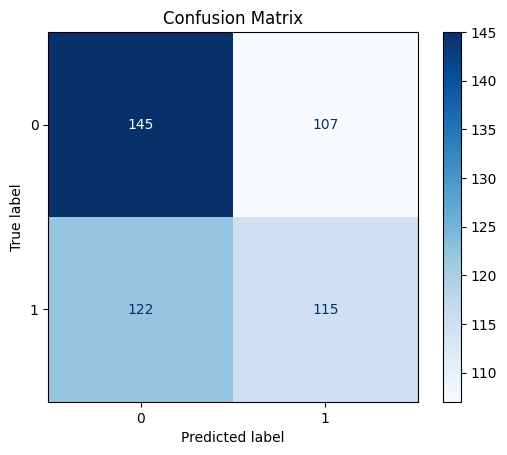

In [7]:
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert emoticons to Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Apply RBF transformation
rbf_feature = RBFSampler(gamma=1.0, random_state=42)  
X_train_rbf = rbf_feature.fit_transform(X_train)
X_valid_rbf = rbf_feature.transform(X_valid)

# Train Random Forest with transformed features
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, max_features='sqrt')  # Adjust n_estimators and max_depth as needed
model.fit(X_train_rbf, y_train)

# Make predictions
y_pred = model.predict(X_valid_rbf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with RBF transformation and Random Forest: {accuracy*100:.4f}%')

# Compute and plot the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



### XGBoost with RBF kernel 

/Users/siya/CS771 mini project /myproject_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with RBF transformation and XGBoost: 49.69%


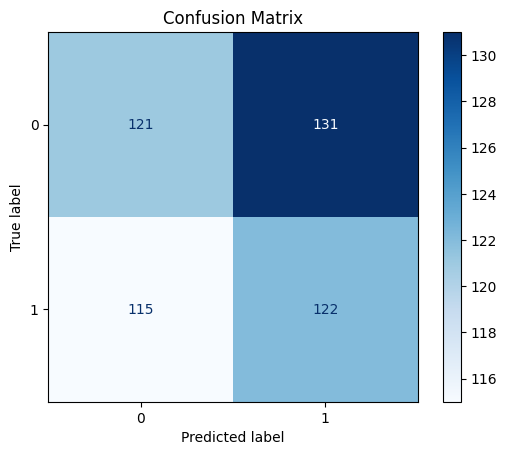

In [8]:
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert emoticons to Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Apply RBF transformation
rbf_feature = RBFSampler(gamma=1.0, random_state=42)  # You can tweak gamma for different transformation behavior
X_train_rbf = rbf_feature.fit_transform(X_train)
X_valid_rbf = rbf_feature.transform(X_valid)

# Train XGBoost with transformed features
model = XGBClassifier(use_label_encoder='False', eval_metric='logloss')
model.fit(X_train_rbf, y_train)

# Make predictions
y_pred = model.predict(X_valid_rbf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with RBF transformation and XGBoost: {accuracy*100:.2f}%')

# Compute and plot the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### SVC with RBF kernel 

Accuracy with SVC and RBF kernel: 56.24%


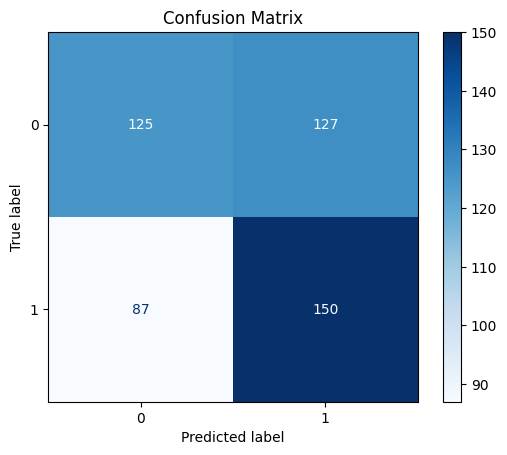

In [9]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert each string of emoticons to their Unicode values
X_train = np.array([[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X])
y_train = np.array(train_emoticon_Y)
X_valid = np.array([[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X])
y_valid = np.array(valid_emoticon_Y)

# fiting the SVC model with RBF kernel
svc_model = SVC(kernel='rbf', gamma='scale', random_state=42)  
svc_model.fit(X_train, y_train)

# predictions
y_pred = svc_model.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with SVC and RBF kernel: {accuracy*100:.2f}%')

# Computing the Confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Logistic Regression with RBF kernel

Accuracy with Gaussian kernel transformation: 51.94%


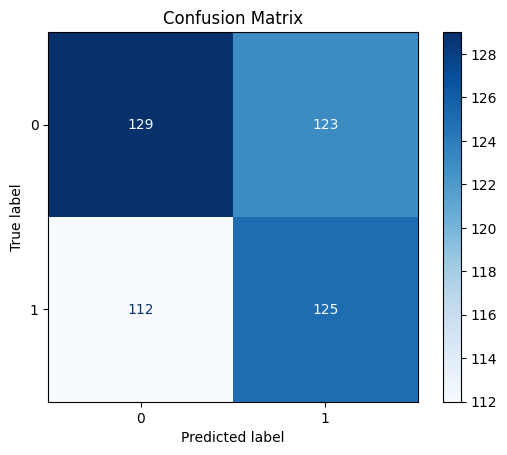

In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Convert each string of emoticons to their Unicode values
X_train = np.array([[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X])
y_train = np.array(train_emoticon_Y)
X_valid = np.array([[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X])
y_valid = np.array(valid_emoticon_Y)

# Define the RBF kernel approximation using RBFSampler
rbf_feature = RBFSampler(gamma=1.0, random_state=42)  

# Create a pipeline that transforms the data and applies logistic regression
pipeline = Pipeline([
    ('rbf', rbf_feature),
    ('log_reg', LogisticRegression(max_iter=100))  
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with Gaussian kernel transformation: {accuracy*100:.2f}%')

# Compute Confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Polynomial kernel with SVC 

/Users/siya/CS771 mini project /myproject_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy with polynomial feature transformation using SVM: 50.92%


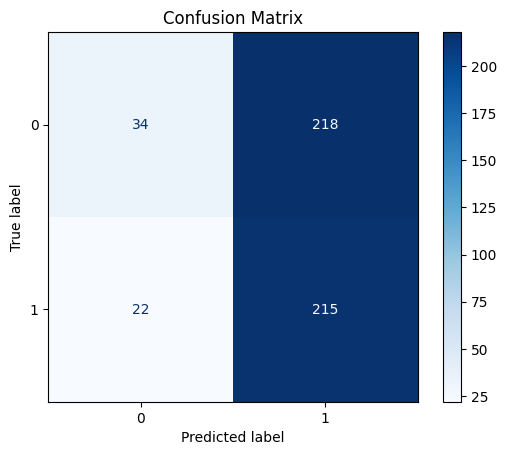

In [11]:
import numpy as np
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Define polynomial features
poly = PolynomialFeatures(degree=4, include_bias=False)

# Training dataset: Convert each string of emoticons to their Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

# Apply polynomial feature transformation (fit only on training data)
X_poly_train = poly.fit_transform(X_train)

# Scale the polynomial features
scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)

# Validation dataset: Convert each string of emoticons to their Unicode values
X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Apply polynomial feature transformation (transform validation data)
X_poly_valid = poly.transform(X_valid)

# Scale the validation features
X_poly_valid_scaled = scaler.transform(X_poly_valid)

# Train a Support Vector Machine model with the transformed features
model = SVC(kernel='poly', degree=5, max_iter=1000) 
model.fit(X_poly_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_poly_valid_scaled)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with polynomial feature transformation using SVM: {accuracy*100:.2f}%')

# Compute Confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Polynomial Kernel with Logistic Regression 

Accuracy with polynomial feature transformation: 58.28%


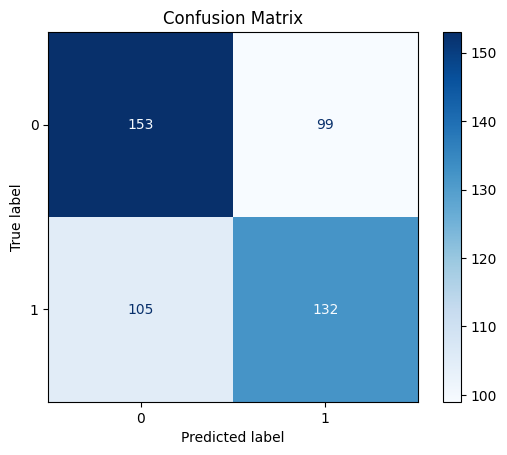

In [12]:
poly = PolynomialFeatures(degree=4, include_bias=False)

# Training dataset : 
# Convert each string of emoticons to their Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

# Apply polynomial feature transformation
X_poly_train = poly.fit_transform(X_train)

#validation dataset 
# Convert each string of emoticons to their Unicode values
X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Apply polynomial feature transformation 
X_poly_valid = poly.transform(X_valid)

# Train a logistic regression model with the transformed features
model = LogisticRegression(max_iter=1000)  # Increase iterations if needed for convergence
model.fit(X_poly_train, y_train)

# Make predictions
y_pred = model.predict(X_poly_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with polynomial feature transformation: {accuracy*100:.2f}%')

#Compute Confusion matrix 
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



### Polynomial Kernel with XGBoost 

Accuracy with polynomial feature transformation and XGBoost: 60.74%


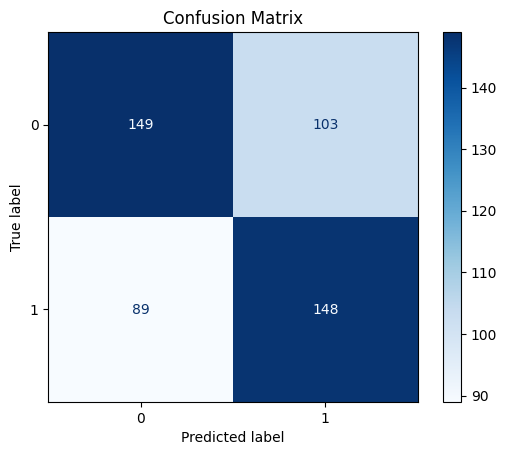

In [13]:
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Step 1: Convert each string of emoticons to their Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Step 2: Apply Polynomial Feature Transformation
# You can adjust the degree to experiment with the complexity
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_valid = poly.transform(X_valid)

# Step 3: Create and Train XGBoost Model
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_clf.fit(X_poly_train, y_train)

# Step 4: Make Predictions on the Validation Set
y_pred = xgb_clf.predict(X_poly_valid)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with polynomial feature transformation and XGBoost: {accuracy*100:.2f}%')

# Step 6: Compute Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Polynomial kernel with Random Forest 

Accuracy with polynomial feature transformation and Random Forest: 57.67%


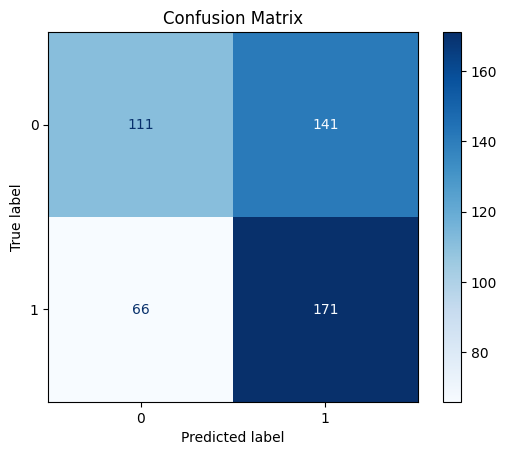

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Convert each string of emoticons to their Unicode values
X_train = [[ord(char) for char in emoticon_string] for emoticon_string in train_emoticon_X]
y_train = train_emoticon_Y

X_valid = [[ord(char) for char in emoticon_string] for emoticon_string in valid_emoticon_X]
y_valid = valid_emoticon_Y

# Step 2: Apply Polynomial Feature Transformation
# You can adjust the degree to experiment with the complexity
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_valid = poly.transform(X_valid)

# Step 3: Create and Train Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_poly_train, y_train)

# Step 4: Make Predictions on the Validation Set
y_pred = rf_clf.predict(X_poly_valid)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy with polynomial feature transformation and Random Forest: {accuracy*100:.2f}%')

# Step 6: Compute Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
